# Question 5.1
Using crime data from the file uscrime.txt, test to see whether there are any outliers in the last column (number of crimes per 100,000 people). Use the grubbs.test function in the outliers package in R.

### Load & Visualize the Data
In this first step of my outliers analysis I loaded the data into a dataframe in R, viewed a quick summary of the data to understand the shape, and then created a boxplot to get a visual representation of outliers in the data set.

In [3]:
# Load libraries
library(dplyr)
library(ggplot2)
library(outliers)
library(tidyr)

# Read in US Crime data
crime <- tbl_df(read.table("uscrime.txt", header = TRUE))

# View the data
head(crime)

M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234
12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084,2.9,6890,12.6,0.034201,20.9995,682


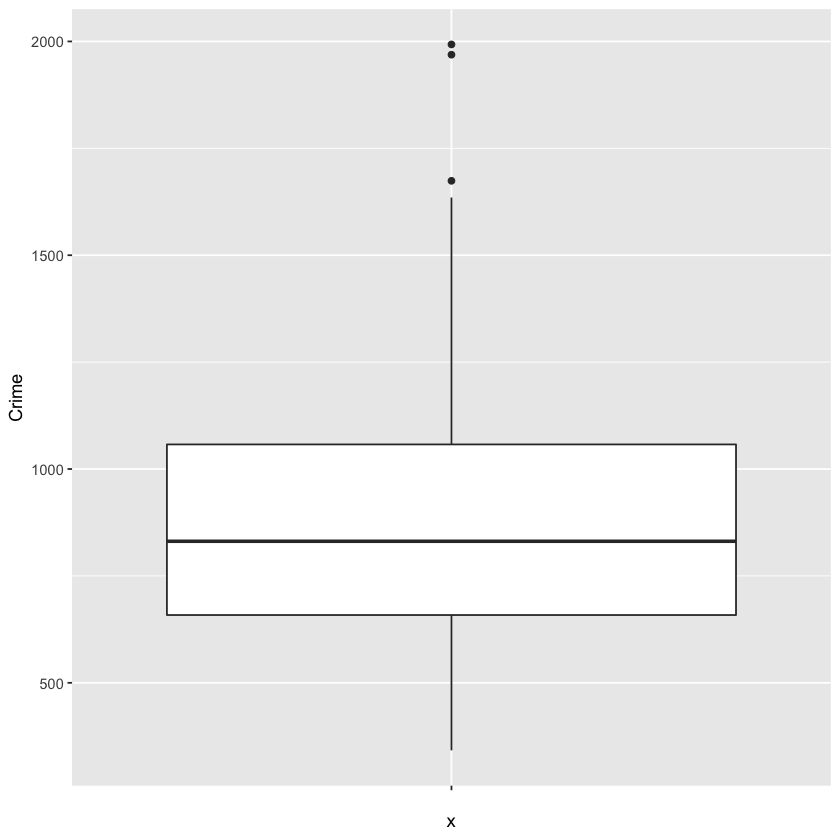

In [4]:
# Get a quick view of the last column Crime (number of crimes per 100,000 people)
ggplot(crime, aes(x = "", y = Crime)) +
  geom_boxplot()

Using the boxplot above, you can clearly see two outliers in the data set on one tail, there may be a third outlier as well, although it is very close to the box plot so it may not be an outlier in reality. We can discover this once we execute the grubbs test. Before executing the Grubbs test, one thing we need to confirm is that the data is normally distributed. This is one of the requirements for this test, and we can confirm this using a shapiro test on the last column of data in the data set. You can see in the output of the shapiro test below, that the data set is normal with a W value of 0.91.

In [5]:
# Test of normality
shapiro.test(crime$Crime)


	Shapiro-Wilk normality test

data:  crime$Crime
W = 0.91273, p-value = 0.001882


The first step at this point is to identify which type of grubbs test to use in outlier detection. Type 20 is for data sets of 30 or fewer values so I ruled that out because our dataset has 47 data points. I also ruled out type = 11 based on a visual analysis of my boxplot above, which only identified outliers on one tail of the data set. Given this analysis, I decided on using type = 10 Grubbs test which can identify one outlier on one tail.

After identifying which type to use, I then had to make the decision around what P value to use. I decided to use a p-value of 0.10 instead of the normal 0.05. P values between 0.05 and 0.10 provide weaker evidence for rejecting the null hypothesis, while a p value of less than 0.05 provides strong evidence. In order for my while loop in the function below to successfully identify outliers, I had to bump up the p-value, and on the 2nd iteration it found an outlier with a p-value less than 0.05 providing evidence that the 2 highest points in the data set are outliers.

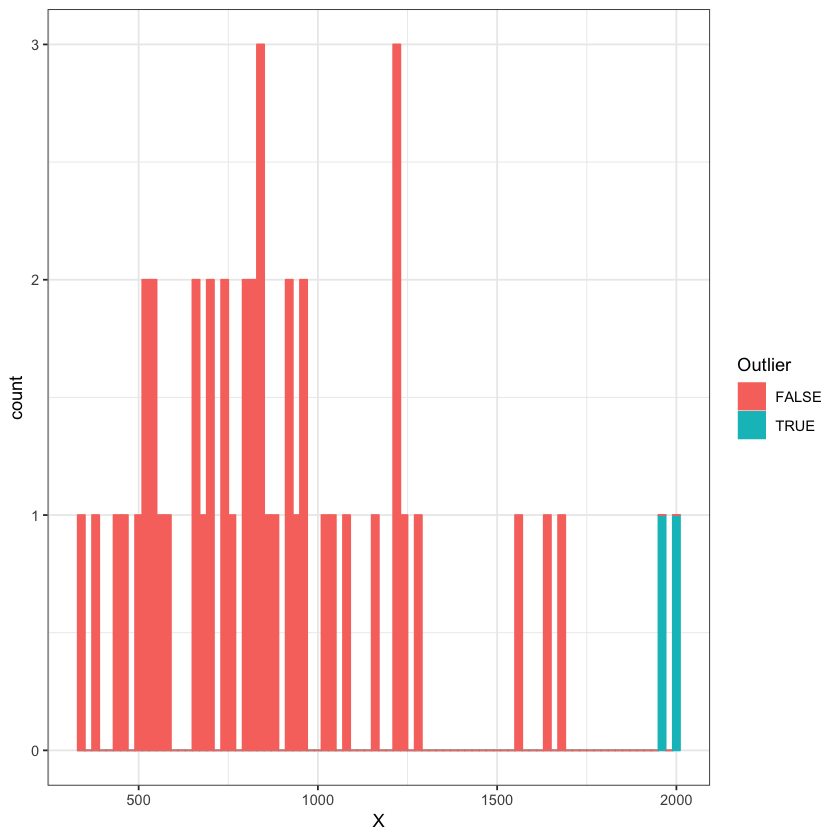

In [7]:
# Function which identifies an outlier, iteratively removes it from the test data set, 
# and attempts to find outliers in the remaining data set
flag_outliers <- function(x) {
  outliers <- NULL
  test <- x
  grubbs.result <- grubbs.test(test, type = 10)
  pv <- grubbs.result$p.value
  while(pv < 0.10) {
    outliers <- c(outliers,as.numeric(strsplit(grubbs.result$alternative," ")[[1]][3]))
    test <- x[!x %in% outliers]
    grubbs.result <- grubbs.test(test)
    pv <- grubbs.result$p.value
  }
  return(data.frame(X=x,Outlier=(x %in% outliers)))
}

outliers <- flag_outliers(crime$Crime)

ggplot(outliers,aes(x=X,color=Outlier,fill=Outlier))+
  geom_histogram(binwidth = 20)+
  theme_bw()

You can see the outliers identified by the grubbs test highlighted in blue. Initially I thought there were more outliers based on the boxplot from above but after iteratively testing the data set using a p-value of 0.10 I identified only 2 outliers with an additional set of 3 points that are above the norm. The outliers identified are 1993 and 1969.

## Question 6.1
#### Describe a situation or problem from your job, everyday life, current events, etc., for which a Change Detection model would be appropriate. Applying the CUSUM technique, how would you choose the critical value and the threshold?

A situation from my job where a Change Detection model would be appropriate is in our student enrollment leading up to a semester. For backgroun, my company is an EdTech company similar to something like EDX, but we are Semester based like a traditional school. We have an enrollment period where students sign up for our programs which lasts 12 weeks up to the start of the semester.

The data that I would use in applying the CUSUM technique is daily enrollment (how many students enroll each day). Ideally, we would see steady enrollment over the course of 12 weeks, almost in a linear fashion. My goal of using CUSUM is to identify when we start to get off track for enrollment so that we can take corrective action and increase our student outreach and enrollment if it falls off.

To choose my critical value and threshold, I would use a data set from a previous semester. We have to adjust for seasonality however because a Winter semester has much different enrollment rates than Fall, so I would use data from the previous successful Winter semester. I would start by taking the average enrollment by day and using the traditional approach of finding the standard deviation of those values and multiplying by 5 for my critical value. To find my threshold I would also use the default route of taking the standard deviation and dividing by two.

I would also do something similar to what I did below, where I would concurrently test a variety of C and T values to account for false positives in the data set.

## Question 6.2
Using July through October daily-high-temperature data for Atlanta for 1996 through 2015, use a CUSUM approach to identify when unofficial summer ends (i.e., when the weather starts cooling off) each year. You can use R if you'd like, but it's straightforward enough that an Excel spreadsheet can easily do the job too.

### Load, structure, and visualize the data
In the first part of my analysis I worked with the data in R to get an understanding of the data. I loaded the data in and got a quick view of the structure of the data. I then reshaped the data from a wide to a long format for use in a visualization.

In [16]:
# Load libraries
library(stringr)
suppressWarnings(library(lubridate))

# Read in temperature data
temps <- tbl_df(read.table("temps.txt", header = TRUE, stringsAsFactors = FALSE))
head(temps)

DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,⋯,X2006,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015
1-Jul,98,86,91,84,89,84,90,73,82,⋯,93,95,85,95,87,92,105,82,90,85
2-Jul,97,90,88,82,91,87,90,81,81,⋯,93,85,87,90,84,94,93,85,93,87
3-Jul,97,93,91,87,93,87,87,87,86,⋯,93,82,91,89,83,95,99,76,87,79
4-Jul,90,91,91,88,95,84,89,86,88,⋯,91,86,90,91,85,92,98,77,84,85
5-Jul,89,84,91,90,96,86,93,80,90,⋯,90,88,88,80,88,90,100,83,86,84
6-Jul,93,84,89,91,96,87,93,84,90,⋯,81,87,82,87,89,90,98,83,87,84


In [17]:
# In this first step I gathered the data from each of the year columns 
# to create a vertical data set. We need day number for vertical line on plot below
temps <- temps %>%
  gather(-DAY, key = "year", value = "temp")%>%
  mutate(year = str_replace(year, "X", "")) %>% 
  mutate(date = dmy(paste(as.character(DAY), year, sep = "-"))) %>%
  arrange(date) %>%
  mutate(day_number = ts(yday(date),frequency=123))

In assessing when the temperatures start to drop and identify when summer ends based on temperature I first created a plot to show temperatures from June through October by year. I added a verticle line for the traditional last day of Summer in the northem hemisphere which is  September 23rd  (day number 267). For all years, it looks like the temperatures actually start to cool off well before the official last day of summer, so this line is not as useful as the Cusum test I will later execute in Excel to find when summer ends by year. It is also clear from the visualization below that there are a lot of spikes in temperature both low and high, so we will most likely have to work with the T and C values to test what works for this data set.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


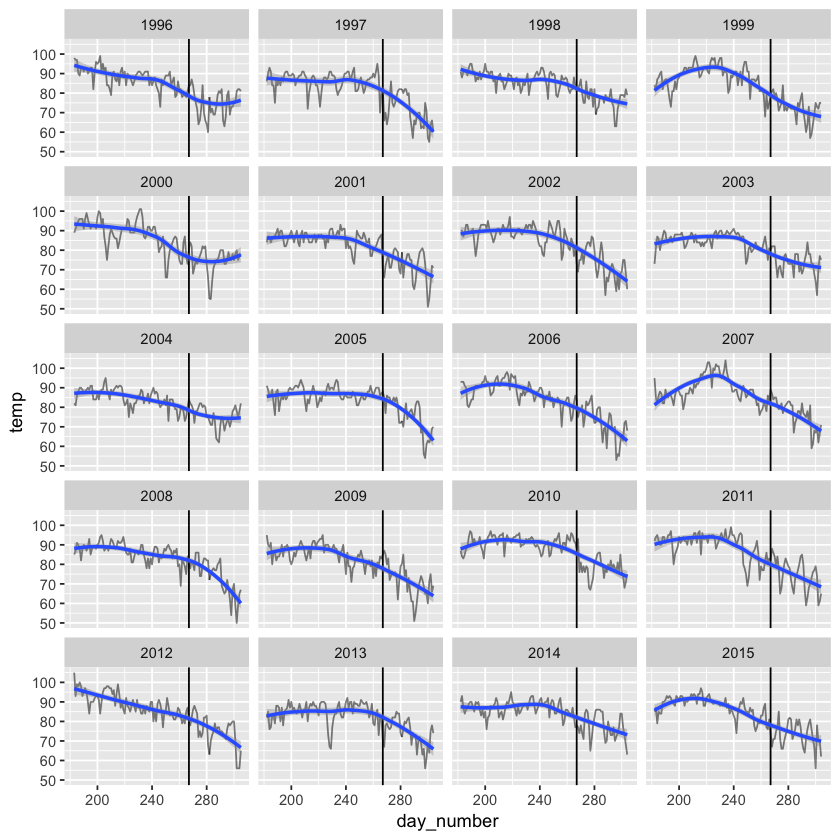

In [13]:
ggplot(temps, aes(x=day_number, y=temp)) +
  geom_line(alpha = 0.5) +
  geom_vline(xintercept = 267) + 
  geom_smooth() +
  facet_wrap(~ year, ncol = 4)

## Question 6.2 Continued in Excel
I took the original data set and worked with it in Excel to find the date each year that temperatures start to officially cool off. You can see in table 1 are the dates highlighted in green when my CUSUM function identified a consistent drop in the temperature, and in table 2 you can see the different values of T and C that I tested.

The Cusum function I used in Excel was the given equation from class: **MAX(0, (Mu - X - C) + Prior State of S)**


<img src="cusum_table.png">

<img src="cusum_test_results.png">

In test 1 I started with the basic values given to us in class. I first calculated Mu in which I averaged every temperature for July through August for all years. To calculate T I took the standard deviation of those same values and multiplied by 5 to get a value of 2.5. To get my C value I took the same standard deviation and divided it in half.

Based on my initial test using a T of 25 and a C of 2.5, the average end of summer that my function identified was August 18th. This is a decent value, as it comes before the technically defined end of summer on September 23rd, however, there were many breaks in my data set and false postivies. You can see which of my test variants had false positives in the last row of table 2. 

After testing a few different values of T and C, I was able to get the Cusum function to flag the end of summer with no false positives when I kept the original value of C at 2.5, but increased the value of T to 55. The final average end of summer across the data set that I identified was September 15th.

## Question 6.2.2
#### Use a CUSUM approach to make a judgment of whether Atlanta’s summer climate has gotten warmer in that time (and if so, when).
To identify if Atlanta's summer climate has gotten warmer I could take 2 different routes. The first is looking at the average temperature for each year, and conducting a grubbs test for outliers. This could give us a result, but might be little unclear given that there are high and low temperatures so it may not be to descriptive. The other route I could take is using the results from the Cusum test above which identified when temperatures started to drop off. This could instruct us how long summers are lasting by year, which we could then reasonably use to identify if the climate is changing.

In [18]:
# Modify data to show year & last day of summer
temps <- temps %>% 
  select(year) %>%
  unique() %>%
  mutate(summer_end_day =
           c(85, 90, 94, 88, 73, 81, 90, 78, 50, 102, 80,
             87, 82, 68, 98, 74, 86, 51, 91, 81))

temps

year,summer_end_day
1996,85
1997,90
1998,94
1999,88
2000,73
2001,81
2002,90
2003,78
2004,50
2005,102


In [19]:
# Execute grubbs test on the results
grubbs.test(temps$summer_end_day)


	Grubbs test for one outlier

data:  temps$summer_end_day
G = 2.33840, U = 0.69707, p-value = 0.1192
alternative hypothesis: lowest value 50 is an outlier


Based on the results of the grubbs test above, we cannot confidently say that the Summer climate in Atlanta is changing. The test identified the lowest value of day 50 as an outlier, which occured in 2004. Additionally with a p value above 0.10 this is very weak evidence of an outlier. We would either need a longer history of data to identify a change over time, or augment this data with additional types of data. I plotted this data below with a linear regression model plotted over the data, and it looks like the length of summer is decreasing over time. I can't say whether or not this is true with this limited data set, potentially another model would be a better descriptor.

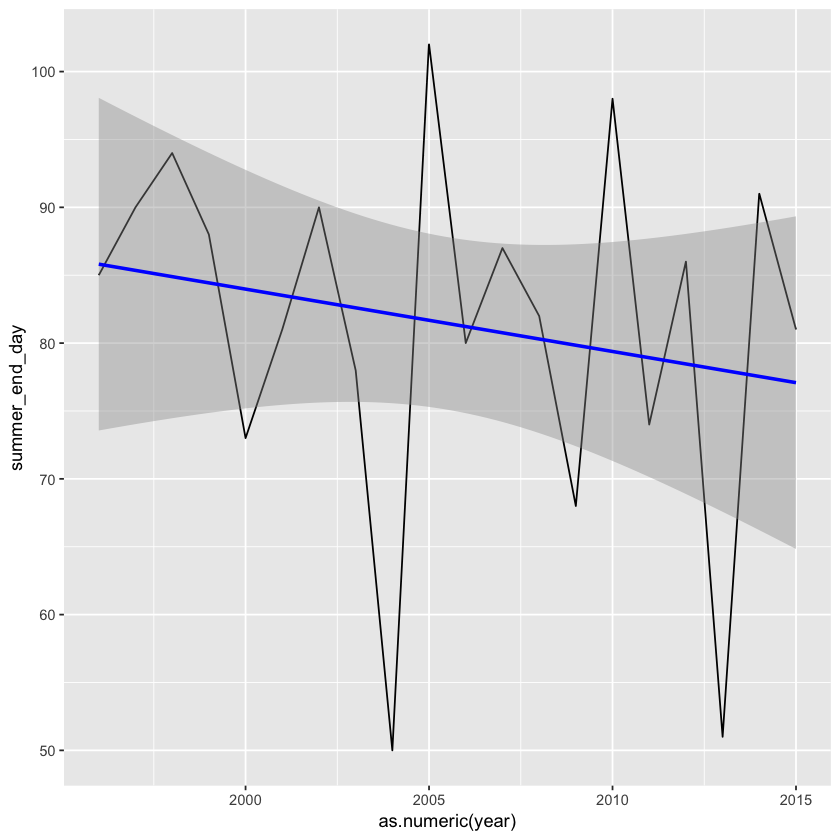

In [20]:
ggplot(temps, aes(as.numeric(year), summer_end_day)) +
  geom_line() +
  geom_smooth(method = "lm", color = "blue")